In [65]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from lml import LML

from copy import deepcopy

from model.layers import KHopfield

from model.lml2 import LML2

from matplotlib import pyplot as plt
# set auto reload
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load mnist, take the build a matrix of all pairwiase distances
# load mnist
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = datasets.MNIST('~/data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('~/data', train=False, download=True, transform=transform)

# load data
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)


In [3]:
# returns a matrix of pairwaise distances
def pair_wise_distance(dataset, norm = 2):
    # get the number of samples
    n = len(dataset)
    # get the dimension of the data
    d = len(dataset[0][0].flatten())
    # create a matrix to store the distances
    distances = torch.zeros((n, n))
    
    # create a batch loader

    batch_size = 1000
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # iterate over the batches
    
    inner_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (x, _) in tqdm(enumerate(loader), total=len(loader)):
        # compute the distances
        for j, (x2, _) in enumerate(inner_loader):
            # compute the distancetorch.cdist(x, x2, p=norm)
            dists = torch.cdist(x.flatten(start_dim=1), x2.flatten(start_dim=1), p=norm)
            distances[i*batch_size:(i+1)*batch_size, j*batch_size:(j+1)*batch_size] = dists
    return distances

In [4]:
# compute the pairwise distances of test data
distances = pair_wise_distance(test_data, norm = 2)

# # save in data folder
torch.save(distances, 'data/mnist_test_distances.pt')
distances = torch.load('data/mnist_test_distances.pt')

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
# plot the first row of distances
distances[0]

tensor([ 0.0000, 36.5752, 27.7038,  ..., 28.9730, 31.2306, 40.4086])

In [6]:
# make a wrapper aroudn mnist dataset
class DatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, index):
        return self.dataset[index][0].flatten(), self.dataset[index][1], index
    def __len__(self):
        return len(self.dataset)
    
# create a dataset wrapper
test_dataset_w = DatasetWrapper(test_data)
test_loader_w = DataLoader(test_dataset_w, batch_size=1, shuffle=False)


In [8]:
# make a hopfield network
hopfield = KHopfield(len(test_dataset_w), 784)
hopfield.set_memories_from_loader(test_loader_w)

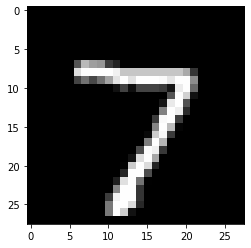

In [9]:
# print first image in test_loader_w
plt.imshow(test_loader_w.dataset[0][0].reshape(28, 28), cmap='gray')

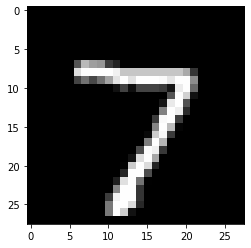

In [10]:
# print first image in memory
plt.imshow(hopfield.memories[0].reshape(28, 28).detach().numpy(), cmap='gray')

In [11]:
hopfield.memories.shape

torch.Size([10000, 784])

In [112]:
test_loader_w = torch.utils.data.DataLoader(test_dataset_w, batch_size=5, shuffle=False)
k=10

# # set list of k zeros
# total_k_recall = torch.zeros(k)
# for batch_idx, batch in enumerate(test_loader):
#     x, y, i = batch
#     # get rows of distance matrix from every element in batch
#     dists = distances[i]
    
#     # get the top k
#     top_k = torch.argsort(dists, dim=1)[:, :k]

#     reported = hopfield(x,  k=k, beta = 3, hopfield_steps=0, index=True)
#     reported_argmax = torch.argmax(reported, dim=1)
#     for j in range(k):
#         k_recall = get_k_recall(top_k[:j], reported_argmax[:j])
#         total_k_recall[j] += torch.sum(k_recall)
#     if batch_idx > 1:
#         break

In [113]:

def get_k_recall(true_top_k, predicted_top_k):
    # true top_k is a torch tensor batch_size x k
    # predicted top_k is a torch tensor batch_size x k
    # compute the recall which is a b vector
    k = true_top_k.shape[1]
    b = true_top_k.shape[0]
    # compute the recall
    recall = torch.zeros(b)
    for i in range(b):
        intersection = np.intersect1d(true_top_k[i].numpy(), predicted_top_k[i].numpy())
        recall[i] = len(intersection)/k
    return recall

In [114]:
def k_recall_exp(test_loader_w, distances, k, seed=None):
    total_k_recall = torch.zeros(k)
    for batch_idx, batch in enumerate(test_loader_w):
        x, y, i = batch
        # get rows of distance matrix from every element in batch
        dists = distances[i]
        
        # get the top k
        top_k = torch.argsort(dists, dim=1)[:, :k]

        scores = hopfield(x,  k=k, beta = 3, hopfield_steps=0, index=True)
        reported_argmax = torch.argmax(scores, dim=1)

        for j in range(1, k+1):
            k_recall = get_k_recall(top_k[:,:j], reported_argmax[:,:j])
            print(k_recall)
            total_k_recall[j-1] += torch.sum(k_recall)
        if batch_idx >=0 :
            break
    return total_k_recall

In [115]:
# get dists[j,k] where j in i and k in i
results = k_recall_exp(test_loader_w, distances, k=5)

tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1.])


In [116]:
results

tensor([5., 5., 5., 5., 5.])